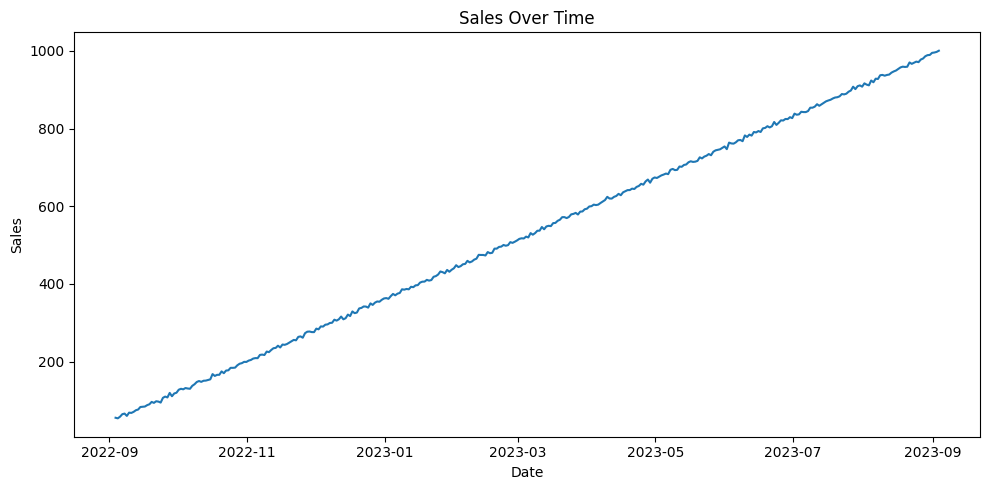

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the data
file_path = ('/workspaces/alternative-time-series-project-omass/sales.csv')
sales_data = pd.read_csv(file_path)
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

# Plotting the time series
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sales_data['sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


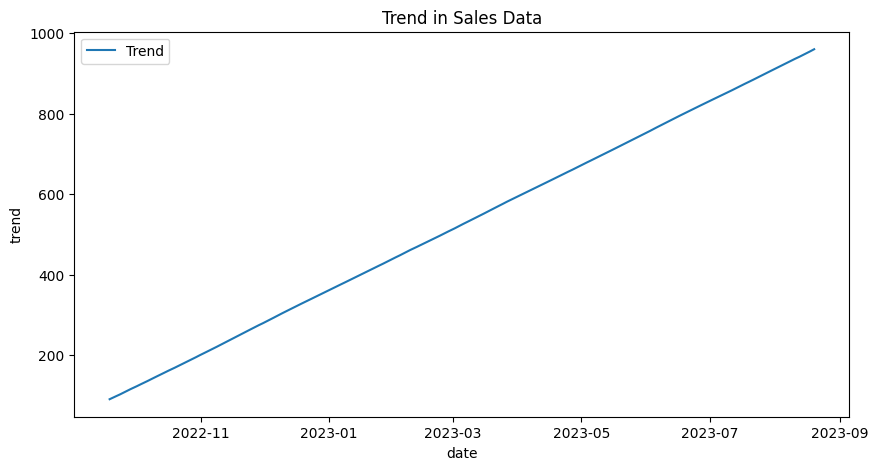

Test Statistic                   0.545414
p-value                          0.986190
# Lags Used                     13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the most common interval between data points (tensor)
time_deltas = sales_data.index.to_series().diff().dropna()
tensor = time_deltas.dt.total_seconds().mode()[0]

# Conduct Dickey-Fuller test for stationarity
adf_test = adfuller(sales_data['sales'])
adf_results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_results[f'Critical Value ({key})'] = value

# Decompose the series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(sales_data['sales'], model='additive', period=30)  
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the trend for visual inspection
plt.figure(figsize=(10, 5))
sns.lineplot(data=trend, label='Trend')
plt.title('Trend in Sales Data')
plt.show()

print(adf_results) # results of Dickey Fuller test


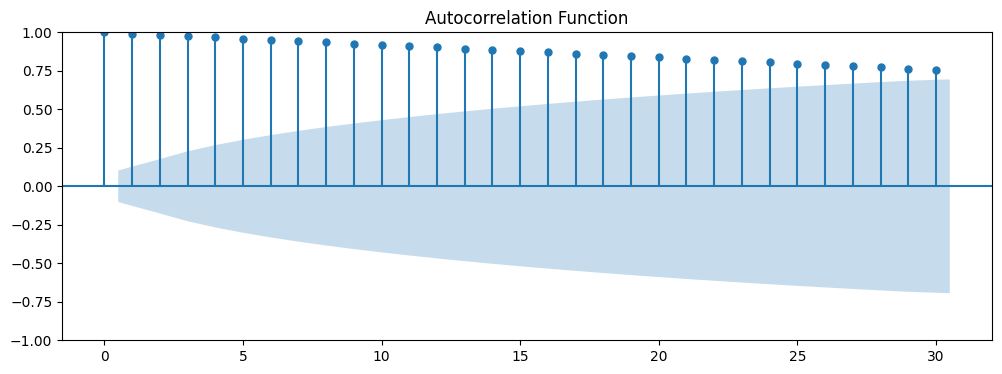

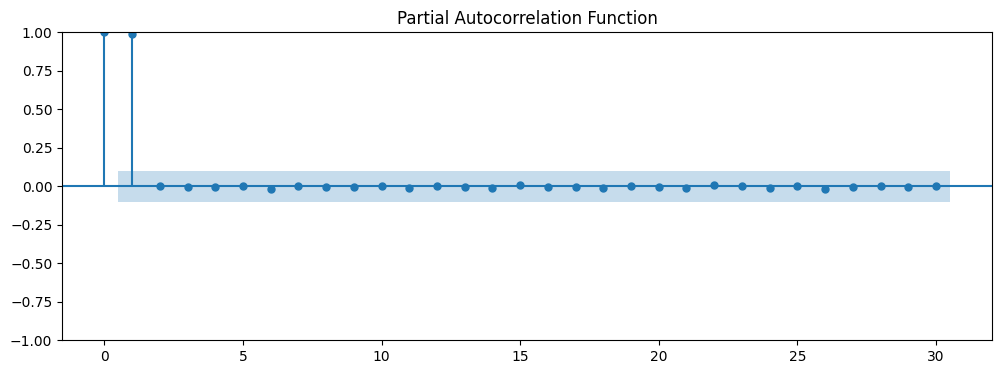

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# shows the correlation of the time series with its own lagged values. Helpful in determining the MA (q) order of an ARIMA model
# Autocorrelation Function (ACF) plot
plt.figure(figsize=(12, 4))
plot_acf(sales_data['sales'], ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function')
plt.show()


# shows the partial correlation of the series with its own lagged values, controlling for the values of the time series at all shorter lags. It helps in determining the AR (p) order of an ARIMA model  
# Partial Autocorrelation Function (PACF) plot
plt.figure(figsize=(12, 4))
plot_pacf(sales_data['sales'], ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Function')
plt.show()


In [12]:
from pmdarima import auto_arima

# Train the ARIMA model with explicit differencing (d=1)
seasonal_period = 30  # Adjust this based on your data's seasonality
model = auto_arima(sales_data['sales'], d=1, seasonal=True, m=seasonal_period, trace=True, error_action='ignore', suppress_warnings=True)

# Model summary
model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=1845.245, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2209.657, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=1843.273, Time=4.01 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=1843.274, Time=0.46 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=1845.262, Time=14.25 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=1843.223, Time=4.59 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=1845.275, Time=17.15 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=1847.247, Time=19.03 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=1843.243, Time=2.52 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=1921.530, Time=1.56 sec
 ARIMA(3,1,2)(1,0,0)[30] intercept   : AIC=1849.753, Time=5.16 sec
 ARIMA(2,1,3)(1,0,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  366
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 30)   Log Likelihood                -912.795
Date:                              Tue, 30 Jan 2024   AIC                           1841.591
Time:                                      01:34:39   BIC                           1872.790
Sample:                                  09-03-2022   HQIC                          1853.990
                                       - 09-03-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.7841      0.555     15.820      0.000       7.696       9.872
ar.L1         -1.4871      0.117    -12.708      0.000      -1.716      -1.258
ar.L2         -0.8918      0.111     -8.063      0.000      -1.109      -0.675
ma.L1          0.4684      0.136      3.436      0.001       0.201       0.736
ma.L2         -0.5356      0.099     -5.392      0.000      -0.730      -0.341
ma.L3         -0.8069      0.129     -6.259      0.000      -1.060      -0.554
ma.S.L30      -0.0786      0.061     -1.284      0.199      -0.199       0.041
sigma2         8.6118      0.670     12.851      0.000       7.298       9.925
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.99   Prob(JB):                         0.65
Heteroskedasticity (H):               0.93   Skew:                             0.10
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

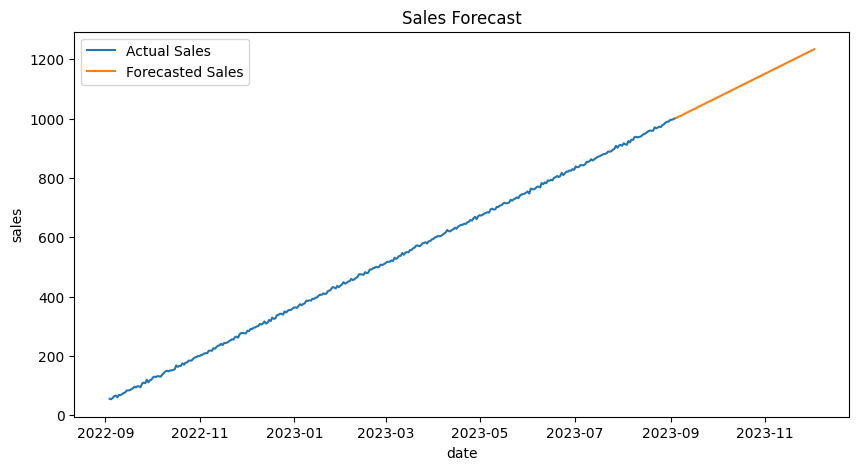

In [13]:
# Forecast future sales
forecast_periods = 90  # Adjust this for your desired forecast length
forecast = model.predict(n_periods=forecast_periods)

# Plotting the forecast
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_data['sales'], label='Actual Sales')
sns.lineplot(data=forecast, label='Forecasted Sales')
plt.title('Sales Forecast')
plt.show()
